In [22]:
import gymnasium as gym
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random

pygame 2.5.2 (SDL 2.28.3, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [24]:
class discretize_action:
    def __init__(self, env) -> None:
        self.env = env
        self.action_space = self.env.action_space

    def discretize_action_space(self, steps_per_dimension):
        """
        Discretizes the action space.

        Parameters:
        - low: The lower bound of the action space.
        - high: The higher bound of the action space.
        - steps_per_dimension: Number of discrete steps per dimension.

        Returns:
        - A list of discretized actions.
        """
        low = self.action_space.low
        high = self.action_space.high

        # Generate a range of values for each dimension
        ranges = [np.linspace(low[i], high[i], steps_per_dimension) for i in range(len(low))]
        
        # Create a meshgrid of all possible combinations
        mesh = np.meshgrid(*ranges)
        
        # Reshape the meshgrid to create a list of actions
        self.actions = np.vstack([m.flatten() for m in mesh]).T
        
        return self.actions
    
    def allocate_action(self, action):
        distances = np.linalg.norm(self.actions - action, axis=1)
        nearest_index = np.argmin(distances)
        return self.actions[nearest_index]


In [25]:
env = gym.make("Swimmer-v4")

def empirical_range(env):
    states = []
    rewards = []
    for i in range(500):
        state, info = env.reset()
        range_reward = 0
        while True:
            states.append(state)
            action = env.action_space.sample()
            state, reward, terminated, truncated, info = env.step(action)
            range_reward += reward
            if terminated or truncated:
                break
        rewards.append(range_reward)
    env.close()
    #print(np.mean(rewards))
    return np.max(states, axis = 0), np.min(states, axis = 0)

state_range = empirical_range(env)

In [26]:
print(state_range)

(array([2.61764628, 1.77789595, 1.7744446 , 2.75212675, 3.44238607,
       3.03272168, 6.30916331, 6.1826078 ]), array([-2.46315669, -1.78013629, -1.77894938, -2.49675038, -3.08568768,
       -3.21718606, -6.21835684, -6.22775535]))


In [41]:
class Fourier_Basis:
  def __init__(self, order, k):
    #self.env = env
    self.order = [order]*k
    self.coefficients = np.array([])

  def get_coefficients(self):
    prods = [range(0, i+1) for i in self.order]
    #print(prods)
    coeffs = [v for v in itertools.product(*prods)]
    self.coefficients = np.array(coeffs)
    return self.coefficients
  
  def value(self, state):
    self.get_coefficients()
    return np.cos(np.pi*np.dot(self.coefficients, state))

class Expected_SARSA_Continuous_Action:
  def __init__(self, env, gamma, order, k):
    self.state_num = env.observation_space.shape[0]
    discrete_actions = discretize_action(env)
    action_list = discrete_actions.discretize_action_space(steps_per_dimension)
    self.action_num = len(action_list)
    self.w = np.random.uniform(-0.001, 0.001, ((order + 1)**k, self.action_num))
    self.gamma = gamma

  #define the greedy policy
  def policy(self, states, epsilon):
    if random.uniform(0, 1) < epsilon:
        return np.random.randint(self.action_num)
    else:
        return states.argmax()

  def apply_weight(self, state): #dot product for linear approximation function with weights vector
    return np.dot(state, self.w)

  def update(self, current, target, reward, state, action, alpha, done):
    error = reward + self.gamma * target* (not done) - current
    #print(error)
    self.w[:, action] += alpha * error * state


def Expected_SARSA_implement(env, alpha, epsilon, order, k, gamma = 0.99):
  trial_reward = []
  for j in range(trials):
    Expected_SAR = Expected_SARSA_Continuous_Action(env, gamma, order, k)
    FB = Fourier_Basis(order, k)
    u_state = state_range[0]
    l_state = state_range[1]
    d_state = u_state - l_state
    #print(d_state)


    rewards = []
    for j in range(episodes):
      s, _ = env.reset()
      reward_ep = 0
      done = False
      state_encoding = (s - l_state) / d_state
      #print(state_encoding)
      state_cos = FB.value(state_encoding)
      state_value = Expected_SAR.apply_weight(state_cos)
      for i in range(episode_length):
        a = Expected_SAR.policy(state_value, epsilon)
        v_i = state_value[a]
        #print(action_list[a])
        s, reward, done, info, _ = env.step(action_list[a])
        next_state = (s - l_state) / d_state
        next_state_cos = FB.value(next_state)
        v_next = epsilon * np.mean(Expected_SAR.apply_weight(next_state_cos)) + (1 - epsilon) * np.max(Expected_SAR.apply_weight(next_state_cos))
        Expected_SAR.update(v_i, v_next, reward, state_cos, a, alpha, done)
        state_encoding = next_state
        state_cos = FB.value(state_encoding)
        state_value = Expected_SAR.apply_weight(state_cos)
        reward_ep += reward
      print(f'Total reward in episodes {j}:', reward_ep)
      rewards.append(reward_ep)
    trial_reward.append(rewards)

  return trial_reward

In [43]:
env = gym.make("Swimmer-v4")
obs = env.reset()

#define the parameters
epsilon = [0.001, 0.01]
order = 2
k = env.observation_space.shape[0]
alpha = [0.01, 0.001]
steps_per_dimension = 7
discrete_actions = discretize_action(env)
action_list = discrete_actions.discretize_action_space(steps_per_dimension)
trials = 5
gamma = 0.99
episodes = 500
episode_length = 999

In [44]:
SM_epsilon_return_SARSA = []
for j in range(len(alpha)):
  learning_return_SARSA = []
  for i in range(len(epsilon)):
    avg_return = Expected_SARSA_implement(env, alpha[j], epsilon[i], order, k, gamma)
    learning_return_SARSA.append(avg_return)
  SM_epsilon_return_SARSA.append(learning_return_SARSA)

Total reward in episodes 0: -3.6902069630981402
Total reward in episodes 1: -19.830986431697955
Total reward in episodes 2: 3.5430772773888664
Total reward in episodes 3: -17.947820254632678
Total reward in episodes 4: 14.270457026821527
Total reward in episodes 5: 11.790668917434113
Total reward in episodes 6: 40.160482418239084
Total reward in episodes 7: -6.809667650286334
Total reward in episodes 8: -13.176350067878204
Total reward in episodes 9: 3.731310999227506
Total reward in episodes 10: -1.4634869121284508
Total reward in episodes 11: 2.5544926869530054
Total reward in episodes 12: 24.808594269733998
Total reward in episodes 13: 17.70710980400514
Total reward in episodes 14: -3.6371575894362405
Total reward in episodes 15: -2.4672999049647757
Total reward in episodes 16: 35.956916782103754
Total reward in episodes 17: -13.485033753520506
Total reward in episodes 18: 4.94805889659146
Total reward in episodes 19: -7.384604279867031
Total reward in episodes 20: -6.08025066394658

C:\Users\chery\AppData\Local\Temp\ipykernel_83788\778573093.py:38: RuntimeWarning: invalid value encountered in scalar subtract
  error = reward + self.gamma * target* (not done) - current


Total reward in episodes 21: -13.434499002148069
Total reward in episodes 22: -23.50663252040937
Total reward in episodes 23: -20.142385376630067
Total reward in episodes 24: -22.701486490414627
Total reward in episodes 25: -19.30614282354793
Total reward in episodes 26: -26.386731502339188
Total reward in episodes 27: -23.70960677170566
Total reward in episodes 28: -26.004388752722434
Total reward in episodes 29: -24.356242344451903
Total reward in episodes 30: -19.973785759638375
Total reward in episodes 31: -20.19893615290651
Total reward in episodes 32: -25.415085494929038
Total reward in episodes 33: -25.45908926673881
Total reward in episodes 34: -22.105847553554923
Total reward in episodes 35: -19.25982890099899
Total reward in episodes 36: -22.998522465387776
Total reward in episodes 37: -25.893638910922522
Total reward in episodes 38: -24.54254912601142
Total reward in episodes 39: -25.318050491731295
Total reward in episodes 40: -22.71836317920792
Total reward in episodes 41:

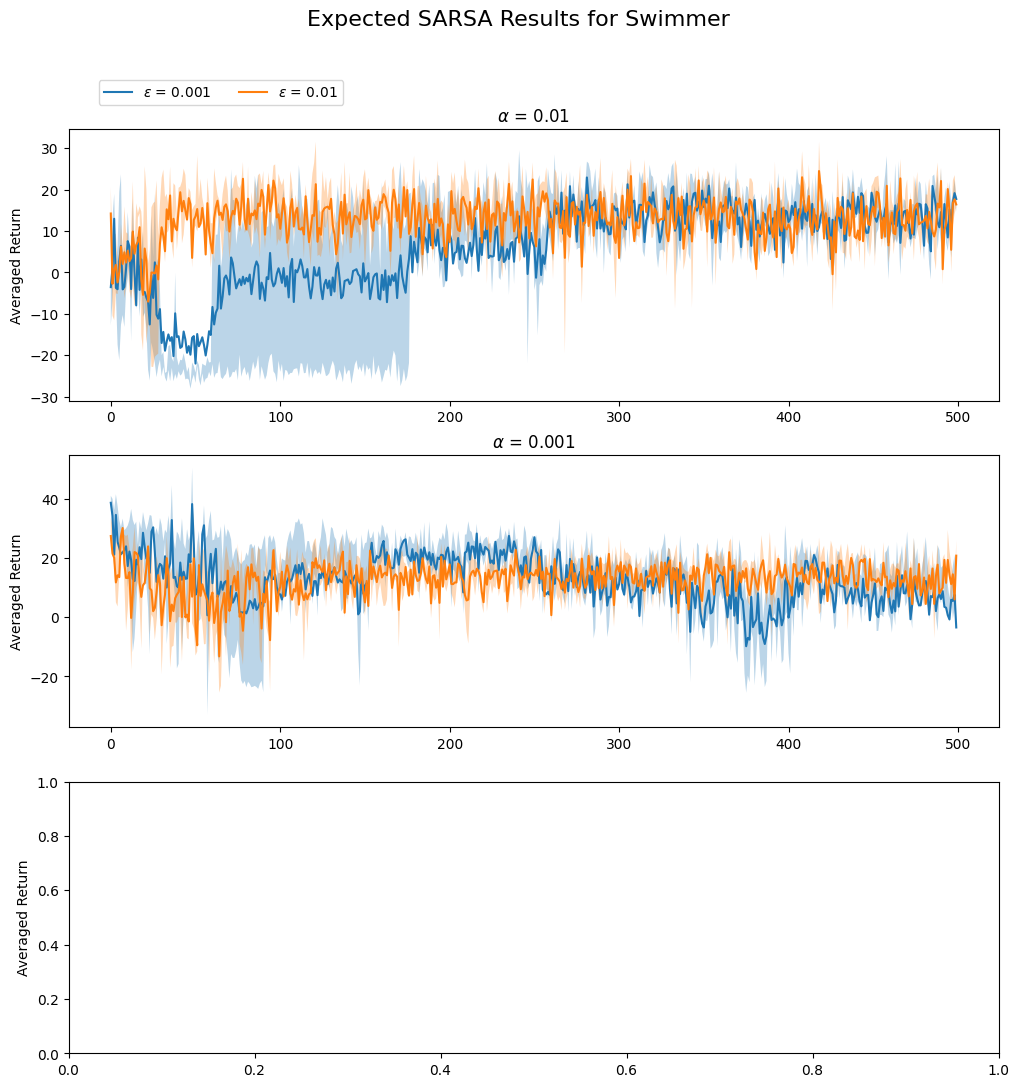

In [45]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

#print(learning_return[0])

plt.rcParams["figure.figsize"]=10,5

for i, learning in enumerate(SM_epsilon_return_SARSA):

  for j, alpha_data in enumerate(learning):
    ar_1_mean = np.mean(alpha_data, axis = 0)
    par_1_75, par_1_25 = np.percentile(alpha_data, [75, 25], axis = 0)
    if i == 0:
      axs[i].plot(range(episodes), ar_1_mean, label = f'${{\\epsilon}}$ = {epsilon[j]}')
    else:
      axs[i].plot(range(episodes), ar_1_mean)
    axs[i].set_title(f'${{\\alpha}}$ = {alpha[i]}')
    axs[i].fill_between(range(episodes), par_1_25, par_1_75, alpha=0.3)

plt.setp(axs, ylabel = 'Averaged Return')
fig.suptitle('Expected SARSA Results for Swimmer', fontsize = 16)

fig.legend(bbox_to_anchor=(0.15, 0.9, 1., .102), loc='lower left',
                      ncol=3, borderaxespad=0.)

In [47]:
import os
import pickle

pkl_path = './Swimmer/'
os.makedirs(pkl_path, exist_ok=True)

dataStore = {}
for i, learning in enumerate(SM_epsilon_return_SARSA):
    dataStore[alpha[i]] = {}
    for j, alpha_data in enumerate(learning):
        dataStore[alpha[i]][epsilon[j]] = alpha_data
    
with open(pkl_path + 'Results_ES_SM_2' + '.pkl', 'wb') as fp:
        pickle.dump(dataStore, fp)
        print('dictionary saved successfully to file')

dictionary saved successfully to file
